In [9]:
import ipyparallel
import os
rc = ipyparallel.Client(profile="mpi")
view = rc[:]
view.apply(os.chdir, os.getcwd())
view['stop'] = True
print view

<DirectView [0, 1, 2, 3,...]>


In [20]:
%%px
from mpi4py import MPI
mpi = MPI.COMM_WORLD
bcast = mpi.bcast
barrier = mpi.barrier
rank = mpi.rank
print "MPI rank: %i/%i" % (mpi.rank,mpi.size)

[stdout:0] MPI rank: 14/20
[stdout:1] MPI rank: 19/20
[stdout:2] MPI rank: 18/20
[stdout:3] MPI rank: 17/20
[stdout:4] MPI rank: 16/20
[stdout:5] MPI rank: 0/20
[stdout:6] MPI rank: 1/20
[stdout:7] MPI rank: 5/20
[stdout:8] MPI rank: 6/20
[stdout:9] MPI rank: 3/20
[stdout:10] MPI rank: 9/20
[stdout:11] MPI rank: 2/20
[stdout:12] MPI rank: 11/20
[stdout:13] MPI rank: 15/20
[stdout:14] MPI rank: 4/20
[stdout:15] MPI rank: 10/20
[stdout:16] MPI rank: 12/20
[stdout:17] MPI rank: 8/20
[stdout:18] MPI rank: 13/20
[stdout:19] MPI rank: 7/20


In [21]:
%%px --noblock

#Experimental Case
scale=21        # Scale could be 21 or 25
index=10         #Refer to DoE_TempFlume.xlsx to check case conditions

#Parameters
dt=0.001            # Maximum dt, adaptive enabled (desired cfl=0.85)
T=4                 # Total Simulation Time
Tank_he=0.03        # Domain he
Caisson_he=0.03     # Interpolation distance of caisson perimeter
enSphere=True        # Replace Caisson with sphere for testing of parameters
radius=0.08





<AsyncResult: execute>

## Update Context

In [22]:
#!pwd

In [23]:
%%px --block
import sys
sys.path.append('/home/user/JorgeMijares/air-water-vv/2d/Interactive/Temp_Flume_GUI')


# Base Model, replace the model with tempFlume_test for testing
# tempFlume is the most stable version until now.
import tempFlume as plant
reload(plant)
import tempFlume_so as plant_so
reload(plant_so)

import proteus
## Required imports
from proteus.iproteus import * 
from proteus import default_n, default_s, default_so, Comm, Context
from proteus.mprans import SpatialTools as st
from petsc4py import PETSc
import pandas as pd
from IPython.display import clear_output

xl = pd.ExcelFile("DoE_TempFlume.xlsx")
df1 = xl.parse(0)
df2 = xl.parse(1)
df3 = xl.parse(2)
df4 = xl.parse(3, header=0, index_col=0)
df5 = xl.parse(4, header=0, index_col=0)

clear_output()
reload(Context)
reload(plant)
reload(plant_so)

if scale==21:
    df_DoE=df4
    df_data=df2

elif scale==25:
    df_DoE=df5
    df_data=df3
else:
    print 'Wrong Scale'
    () + 1
status=df_DoE['Finished'].tolist()[index]
#if status == 'Completed':
#    continue
iFlow=df_DoE['Flow Speed'].tolist()[index]
iDepth=df_DoE['Depth'].tolist()[index]
iOffset=df_DoE['Offset'].tolist()[index]
tagFlow=df_data['Speed Tags'].tolist()[iFlow]
tagDepth=df_data['Depth Tags'].tolist()[iDepth]
tagOffset=df_data['Offset Tags'].tolist()[iOffset]

flowSpeed=df_data['Flow Speed'].tolist()[iFlow]
waterLevel=df_data['Depth'].tolist()[iDepth]
offset=df_data['Offset'].tolist()[iOffset]

#Change Context
plant.opts.water_level=waterLevel
plant.opts.inflow_velocity=flowSpeed
plant.opts.outflow_velocity=flowSpeed
plant.opts.caisson_scale=float(scale)
plant.opts.caisson_Yoffset=-offset


plant.opts.sphere=enSphere
plant.opts.sphereRadius=radius
plant.opts.dt_fixed = dt
plant.opts.T = T
plant.opts.he = Tank_he
plant.opts.he_caisson=Caisson_he

plant.Update_Model()

Context.setFromModule(plant,mutable=True)
ct = Context.get()
# numerical simulation options
plant_so.ct=ct
so = plant_so
so.tnList = [0.0,plant.dt_init]+[i*plant.dt_fixed for i in range(1,plant.nDTout+1)]
info = open("TimeList.txt","w")
for time in so.tnList:
    info.write(str(time)+"\n")
info.close()
plant_so.tnList=so.tnList
pList=[]
nList=[]
so.sList=[]
OptDB = PETSc.Options()
for (p,n) in so.pnList:
    so.sList.append(default_s)
    pList.append(__import__(p))
    reload(pList[-1])
    nList.append(__import__(n))
    reload(nList[-1])
    pList[-1].name = p
    nList[-1].multilevelLinearSolver = default_n.KSP_petsc4py
    nList[-1].levelLinearSolver = default_n.KSP_petsc4py
    OptDB.setValue(nList[-1].linear_solver_options_prefix+"ksp_type", "preonly")
    OptDB.setValue(nList[-1].linear_solver_options_prefix+"pc_type", "lu")
    OptDB.setValue(nList[-1].linear_solver_options_prefix+"pc_factor_mat_solver_package","superlu_dist")
opts.save_dof = True
opts.dataDir='.'
opts.probDir='.'
opts.logLevel=7
opts.verbose=True
opts.viewMesh=True


## Numerical Solution Object and Thread

In [24]:
%%px
ns = NumericalSolution.NS_base(so, pList, nList, so.sList, opts)

In [25]:
%%px --noblock
from threading import Thread
simulation_thread = Thread(target = lambda : ns.calculateSolution('run1'))

<AsyncResult: execute>

## Monitor functions

In [16]:
import numpy as np
ranks = view['rank']
rank_indices = np.argsort(ranks)

def mpi_order(seq):
    """Return elements of a sequence ordered by MPI rank.

    The input sequence is assumed to be ordered by engine ID."""
    return [seq[x] for x in rank_indices]

showTriangles=True
showAir=False
def plot_current_results():
    global t_0, plt0
    """Makes a blocking call to retrieve remote data and displays the solution mesh
    as a contour plot.
    
    Parameters
    ----------
    in_place : bool
        By default it calls clear_output so that new plots replace old ones.  Set
        to False to allow keeping of all previous outputs.
    """
    import numpy as np
    import matplotlib.tri as mtri
    import math
    global nn, x, y, vof, triangles, t, phi, u, v, cfl, p, dt
    view.apply_sync(load_simulation_globals)
    x = np.concatenate(mpi_order(view['x']))
    y = np.concatenate(mpi_order(view['y']))
    u = np.concatenate(mpi_order(view['u']))
    v = np.concatenate(mpi_order(view['v']))
    vof = np.concatenate(mpi_order(view['vof']))
    shifts = np.cumsum([0]+mpi_order(view['nn'])[:-1])
    flat_triangles = np.concatenate([ tri + shift for tri,shift in zip(mpi_order(view['triangles']), shifts) ])

    t = mpi_order(view['t'])[0]
    phi = np.concatenate(mpi_order(view['phi']))
    cfl = mpi_order(view['cfl'])[0]
    p = np.concatenate(mpi_order(view['p']))
    dt = mpi_order(view['dt'])[0]

    Vmax=np.amax(np.sqrt(u[:]**2 + v[:]**2))
    print "u_max={0:.3f}, v_max={1:.3f}, Vmax={2:.3f}, cfl={3:.3f}, dt={4:.5f}".format(np.amax(u[:]),
                                                           np.amax(v[:]),
                                                           Vmax,
                                                           np.asarray(cfl).max()*dt,
                                                           dt
                                                           )

    plt.clf()
    triang = mtri.Triangulation(x, y, flat_triangles)
    dim=[x.max(),y.max()]
    xg = np.linspace(0, dim[0], 20)
    yg = np.linspace(0, dim[1], 20)
    xi, yi = np.meshgrid(xg,yg)
    
    wvof = np.ones(vof.shape,'d')
    if showAir:
        wvof = vof
    else:
        wvof -= vof
            
    plt.xlabel(r'z[m]')
    plt.ylabel(r'x[m]')

    if showTriangles==True:
        plt.triplot(x,y,flat_triangles, linewidth=0.5)
    plt.tricontourf(x,y,flat_triangles,np.sqrt(u[:]**2 + v[:]**2))
    clb=plt.colorbar(orientation='horizontal')
    #clb = plt.colorbar()
    #clb.set_label('Vmax', labelpad=-40, y=1.05, rotation=0)
    clb.set_label('Vmax')
    #plt.tricontourf(x,y,triangles,wvof)
    plt.tricontour(x,y,flat_triangles,phi,[0], linewidth=4)
    #u_interp_lin = mtri.LinearTriInterpolator(triang, u[:])
    #v_interp_lin = mtri.LinearTriInterpolator(triang, v[:])
    #u_lin = u_interp_lin(xi, yi)
    #v_lin = v_interp_lin(xi, yi)
    #plt.streamplot(xg, yg, u_lin, v_lin,color='k')
    plt.title('T=%3.5e' % (t,))
    plt.xlim((x.min(),dim[0]))
    t_0=t
    plt.show()
    fig.canvas.draw()
    return plt

'''Some plotting and monitoring utilities
'''
def load_simulation_globals():
    """Put some variables we need in engine namespace.

    These can then be retrieved by clients for inspection, visualization, etc.
    """
    global nn, x, y, vof, triangles, t, phi, u, v, cfl, p, dt
    model_vof = ns.modelList[1].levelModelList[-1]
    model_ls = ns.modelList[2].levelModelList[-1]
    # save solution and grid data for plotting purposes
    cfl = ns.modelList[0].levelModelList[-1].q[('cfl',0)]
    dt = ns.systemStepController.dt_system
    x = ns.modelList[0].levelModelList[-1].mesh.nodeArray[:,0]
    y = ns.modelList[0].levelModelList[-1].mesh.nodeArray[:,1]
    triangles = ns.modelList[0].levelModelList[-1].mesh.elementNodesArray
    p = ns.modelList[0].levelModelList[-1].u[0].dof
    u = ns.modelList[0].levelModelList[-1].u[1].dof
    v = ns.modelList[0].levelModelList[-1].u[2].dof
    vof = ns.modelList[1].levelModelList[-1].u[0].dof_last
    phi = ns.modelList[2].levelModelList[-1].u[0].dof_last
    nn = len(x)
    #print "p={0}, u={1}, v={2}, triangles={3}, vof={4}, phi={5}".format(len(p),len(u),len(v),len(triangles),len(vof),len(phi))
    t=ns.systemStepController.t_system
    cfl*=dt
    
def simulation_alive():
    """Return True if the simulation thread is still running on any engine.
    """
    return any(view.apply_sync(lambda: simulation_thread.is_alive()))

def monitor_simulation(refresh=5.0):
    global t_0
    """Monitor the simulation progress and call plotting routine.

    Supress KeyboardInterrupt exception if interrupted, ensure that the last 
    figure is always displayed and provide basic timing and simulation status.

    Parameters
    ----------
    refresh : float
      Refresh interval between calls to retrieve and plot data.  The default
      is 5s, adjust depending on the desired refresh rate, but be aware that 
      very short intervals will start having a significant impact.

    """
    import datetime as dt, time
    if not simulation_alive():
        plt=plot_current_results()
        print 'Simulation has already finished, no monitoring to do.'
        error= True
        return error
    t_0=0.
    t0 = dt.datetime.now()
    fig = None
    try:
        while simulation_alive():

            plt=plot_current_results()
            error= False
            tmon = dt.datetime.now() - t0
            print 'Monitored for: %s. at t=%12.5e' % (tmon,view.apply_sync(lambda: ns.systemStepController.t_system)[0])
            time.sleep(refresh) # so we don't hammer the server too fast
    except (KeyboardInterrupt):#, error.TimeoutError):
        msg = 'Monitoring interrupted, simulation is ongoing!'
    else:
        if view.apply_sync(lambda: ns.systemStepController.converged()):
            msg =  "\x1b[31mStep Failed at t=%12.5e \x1b[0m" % (view.apply_sync(lambda: ns.systemStepController.t_system)[0])
            error= True
        else:
            msg = 'Simulation completed!'

    tmon = dt.datetime.now() - t0
    print msg
    print 'Monitored for: %s.' % tmon
    return error
    
    


## Start Simulation

In [17]:
%%px
simulation_thread.start()

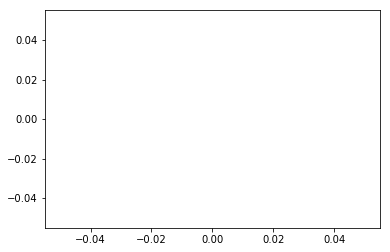

u_max=0.458, v_max=0.279, Vmax=0.458, cfl=0.153, dt=0.01000


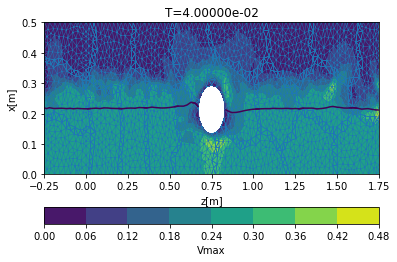

Monitored for: 0:00:17.953255. at t= 2.30000e-01
u_max=0.542, v_max=0.484, Vmax=0.542, cfl=0.203, dt=0.01000


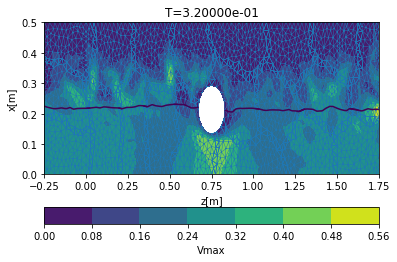

Monitored for: 0:00:45.707842. at t= 4.82500e-01
u_max=nan, v_max=nan, Vmax=nan, cfl=0.006, dt=0.00031


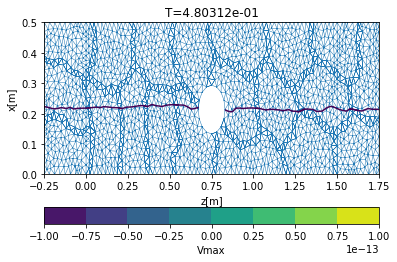

Monitored for: 0:01:11.229222. at t= 4.80020e-01
Step Failed at t= 4.80020e-01 
Monitored for: 0:01:16.674997.


True

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
fig=plt.figure()
plt.plot([])
plt.show()
showTriangles=True
showAir=False
monitor_simulation(refresh=5.0)